In [1]:
import openai as openai
import os
import json
from tqdm import tqdm
import time
import random
from pydantic import BaseModel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

api_key = ''
with open('../../openai.txt', 'r') as file:
    api_key = file.read().replace('\n', '')

client = openai.OpenAI(api_key=api_key)

In [2]:
def list_models():
    """
    List all available models in the OpenAI API.
    """
    models = client.models.list()
    print("Available models:")

    model_ids = []
    for model in models.data:
        model_ids.append(model.id)

    model_ids.sort()
    for model_id in model_ids:
        print(model_id)

# list_models(client)

In [3]:
def costs(prompt_tokens, completion_tokens):
    """
    Calculate the costs based on the number of tokens used.
    Args:
        prompt_tokens (int): The number of prompt tokens used.
        completion_tokens (int): The number of completion tokens used.
    Returns:
        float: The total cost in dollars.
    """
    if model_used == 'gpt-4o-mini':
        price_per_1m_input_tokens = 0.15
        price_per_1m_output_tokens = 0.6
    elif model_used == 'gpt-4o':
        price_per_1m_input_tokens = 2.5
        price_per_1m_output_tokens = 10
    elif model_used == 'o4-mini':
        price_per_1m_input_tokens = 1.10
        price_per_1m_output_tokens = 4.40
    else:
        raise ValueError(
            "Model not set or not supported for cost calculation.")
    total_cost = ((prompt_tokens / 1000000) * price_per_1m_input_tokens) + \
        ((completion_tokens / 1000000) * price_per_1m_output_tokens)
    return total_cost

In [ ]:
class StructuredResponse(BaseModel):
    difference: int
    explanation: str


def llm_call(prompt):
    """
    Call the OpenAI API to get a response based on the provided system and user prompts.
    Args:
        prompt (str): The prompt to send to the OpenAI API.
    Returns:
        tuple: A tuple containing the answer, prompt tokens, completion tokens, and total tokens.
    """
    global global_prompt_tokens, global_completion_tokens

    retries = 0
    max_completion_tokens = 2000
    while True:
        try:
            response = client.beta.chat.completions.parse(
                model=model_used,
                messages=[
                    {"role": "system", "content": prompt}
                ],
                max_completion_tokens=max_completion_tokens,
                response_format=StructuredResponse
            )
            break
        except openai.LengthFinishReasonError as e:
            # Retry with larger max_completion_tokens
            max_completion_tokens *= 2

            prompt_tokens += e.completion.usage.prompt_tokens
            completion_tokens += e.completion.usage.completion_tokens
            total_tokens += e.completion.usage.total_tokens

            global_prompt_tokens += e.completion.usage.prompt_tokens
            global_completion_tokens += e.completion.usage.completion_tokens
        except Exception as e:
            retries += 1
            backoff_time = (2 ** retries) + random.random()
            print(f"Retrying in {backoff_time:.2f} seconds...")
            time.sleep(backoff_time)

    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.completion_tokens
    total_tokens = response.usage.total_tokens

    global_prompt_tokens += response.usage.prompt_tokens
    global_completion_tokens += response.usage.completion_tokens

    answer = response.choices[0].message.parsed.model_dump()

    # Uncomment the following lines to simulate a mock response
    # answer = {
    #     "difference": random.choice([-2, -1, 1, 2]),
    #     "explanation": "This is a mock response."
    # }
    # prompt_tokens = 100
    # completion_tokens = 200
    # total_tokens = prompt_tokens + completion_tokens

    # global_prompt_tokens += prompt_tokens
    # global_completion_tokens += completion_tokens

    return answer, prompt_tokens, completion_tokens, total_tokens

In [5]:
def comparison(file1_key, file2_key, first, f_number, f_student_level, f_materials, second, s_number, s_student_level, s_materials, topic, concepts, criteria, c_question):
    prompt = f"""
    You are an expert teacher in the field of reflection questions. Your task is to evaluate two responses containing a single reflective question based on given criteria. Not all key concepts need to be present in the question.
    
    The topic is {topic}.
    The key concepts are {concepts}
    The criteria is {criteria}: {c_question}
    
    Provide a difference score from list [-2, -1, 1, 2]. The more negative the score, the better is the first question over the second. The more positive the score, the better is the second question over the first. Then provide a brief explanation of the chosen difference (at most 2 sentences).

    Question 1: 
    {first}
    Question 2: 
    {second}
    """

    answer, pt, ct, tt = llm_call(prompt)

    return {
        file1_key: f_number,
        file1_key + '_question': first,
        file1_key + '_student_level': f_student_level,
        file1_key + '_materials': f_materials,
        file2_key: s_number,
        file2_key + '_question': second,
        file2_key + '_student_level': s_student_level,
        file2_key + '_materials': s_materials,
        'criteria': criteria,
        'difference': answer['difference'],
        'explanation': answer['explanation'],
        'prompt_tokens': pt,
        'completion_tokens': ct,
        'total_tokens': tt,
    }

In [6]:
def load_data(files, count):
    data = {}
    for filename in files:
        file_key = os.path.splitext(filename)[0]
        data[file_key] = []
        with open(filename, 'r') as f:
            loaded_data = json.load(f)

            combinations = [[True, True], [True, False],
                            [False, True], [False, False]]

            for i, comb in enumerate(combinations):
                student_level = comb[0]
                materials = comb[1]

                # Get up to 'count' items for each combination
                for item in loaded_data:
                    if len(data[file_key]) >= (i + 1) * count:
                        break
                    if (item['metadata']['student_level'] == student_level and
                            item['metadata']['materials'] == materials):
                        data[file_key].append(item)
    return data

In [7]:
def evaluate(file1, file2, count, topic, concepts):
    file1_name = file1.split('iter.json')[0]
    file2_name = file2.split('iter.json')[0]

    file1_key = os.path.splitext(file1)[0]
    file2_key = os.path.splitext(file2)[0]

    results = file1_name + "VS" + file2_name + ".csv"

    for filename in os.listdir('.'):
        if filename.startswith(results):
            os.remove(filename)

    data = load_data([file1, file2], count)

    # The list of criteria
    criteria = {
        "clarity": "Is the question clearly stated and easy to understand?",
        "relevance": "Is the question relevant to the topic?",
        "depth": "Does the question encourage critical thinking and deeper exploration of the topic?",
        "overall_quality": "Is the question of high quality overall, well-structured and thought-provoking?",
    }

    rows = []
    for i, item in tqdm(enumerate(data[file1_key]), desc="Processing items", total=len(data[file1_key])):
        for j, item2 in enumerate(data[file2_key]):
            for c in criteria:
                for message in reversed(item['student']):
                    if message['role'] == 'assistant':
                        f = message['content']
                        break
                for message in reversed(item2['student']):
                    if message['role'] == 'assistant':
                        s = message['content']
                        break

                f_sl = item['metadata']['student_level']
                f_m = item['metadata']['materials']
                f_n = item['metadata']['attempt']
                s_sl = item2['metadata']['student_level']
                s_m = item2['metadata']['materials']
                s_n = item2['metadata']['attempt']

                rows.append(comparison(
                    file1_key, file2_key, f, f_n, f_sl, f_m, s, s_n, s_sl, s_m, topic, concepts, c, criteria[c]))

    df = pd.DataFrame(rows)
    df.to_csv(results, index=False)


def evaluation(files, count, topic, concepts):
    # Call the evaluate function for each pair of files
    for i in range(len(files)):
        for j in range(i + 1, len(files)):
            print(f"Evaluating {files[i]} vs {files[j]}")
            evaluate(files[i], files[j], count, topic, concepts)

In [ ]:
model_used = "o4-mini"

global_prompt_tokens = 0
global_completion_tokens = 0

# Experiment settings
files = ['free10iter.json', 'fixed5iter.json', 'fixed10iter.json'] # At least 2 files must be in this list
topic = "Basics of how the internet works"
concepts = """
 - Decentralization of the internet
 - Servers, datacenters and routers
 - Server vs client
 - Data packets
 - IP addresses
"""
count = 5  # How many members of each combination from each file to use

evaluation(files, count, topic, concepts)

Evaluating free10iter.json vs fixed5iter.json


Processing items: 100%|██████████| 20/20 [2:14:09<00:00, 402.45s/it]  


Evaluating free10iter.json vs fixed10iter.json


Processing items: 100%|██████████| 20/20 [2:08:29<00:00, 385.49s/it]  


Evaluating fixed5iter.json vs fixed10iter.json


Processing items: 100%|██████████| 20/20 [2:23:58<00:00, 431.91s/it]  


In [9]:
print("Total prompt tokens:", global_prompt_tokens)
print("Total completion tokens:", global_completion_tokens)
print(costs(global_prompt_tokens, global_completion_tokens))

Total prompt tokens: 2827280
Total completion tokens: 2025518
12.022287200000001


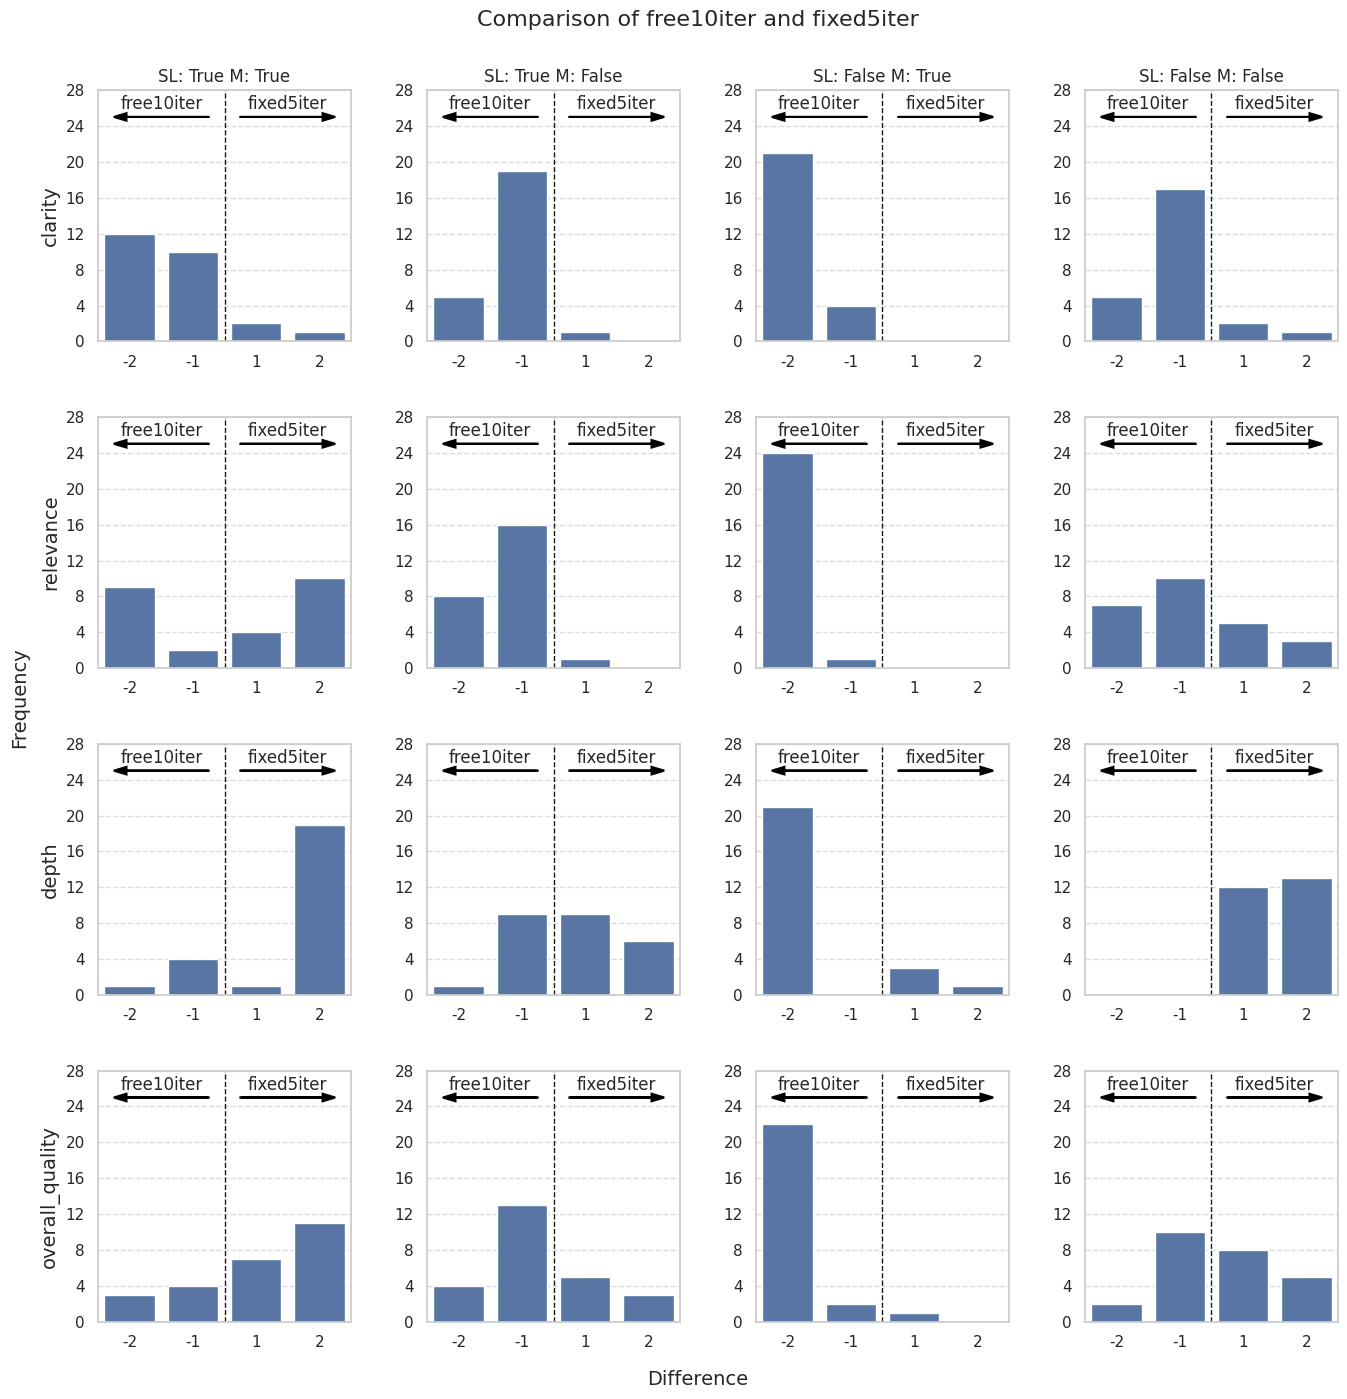

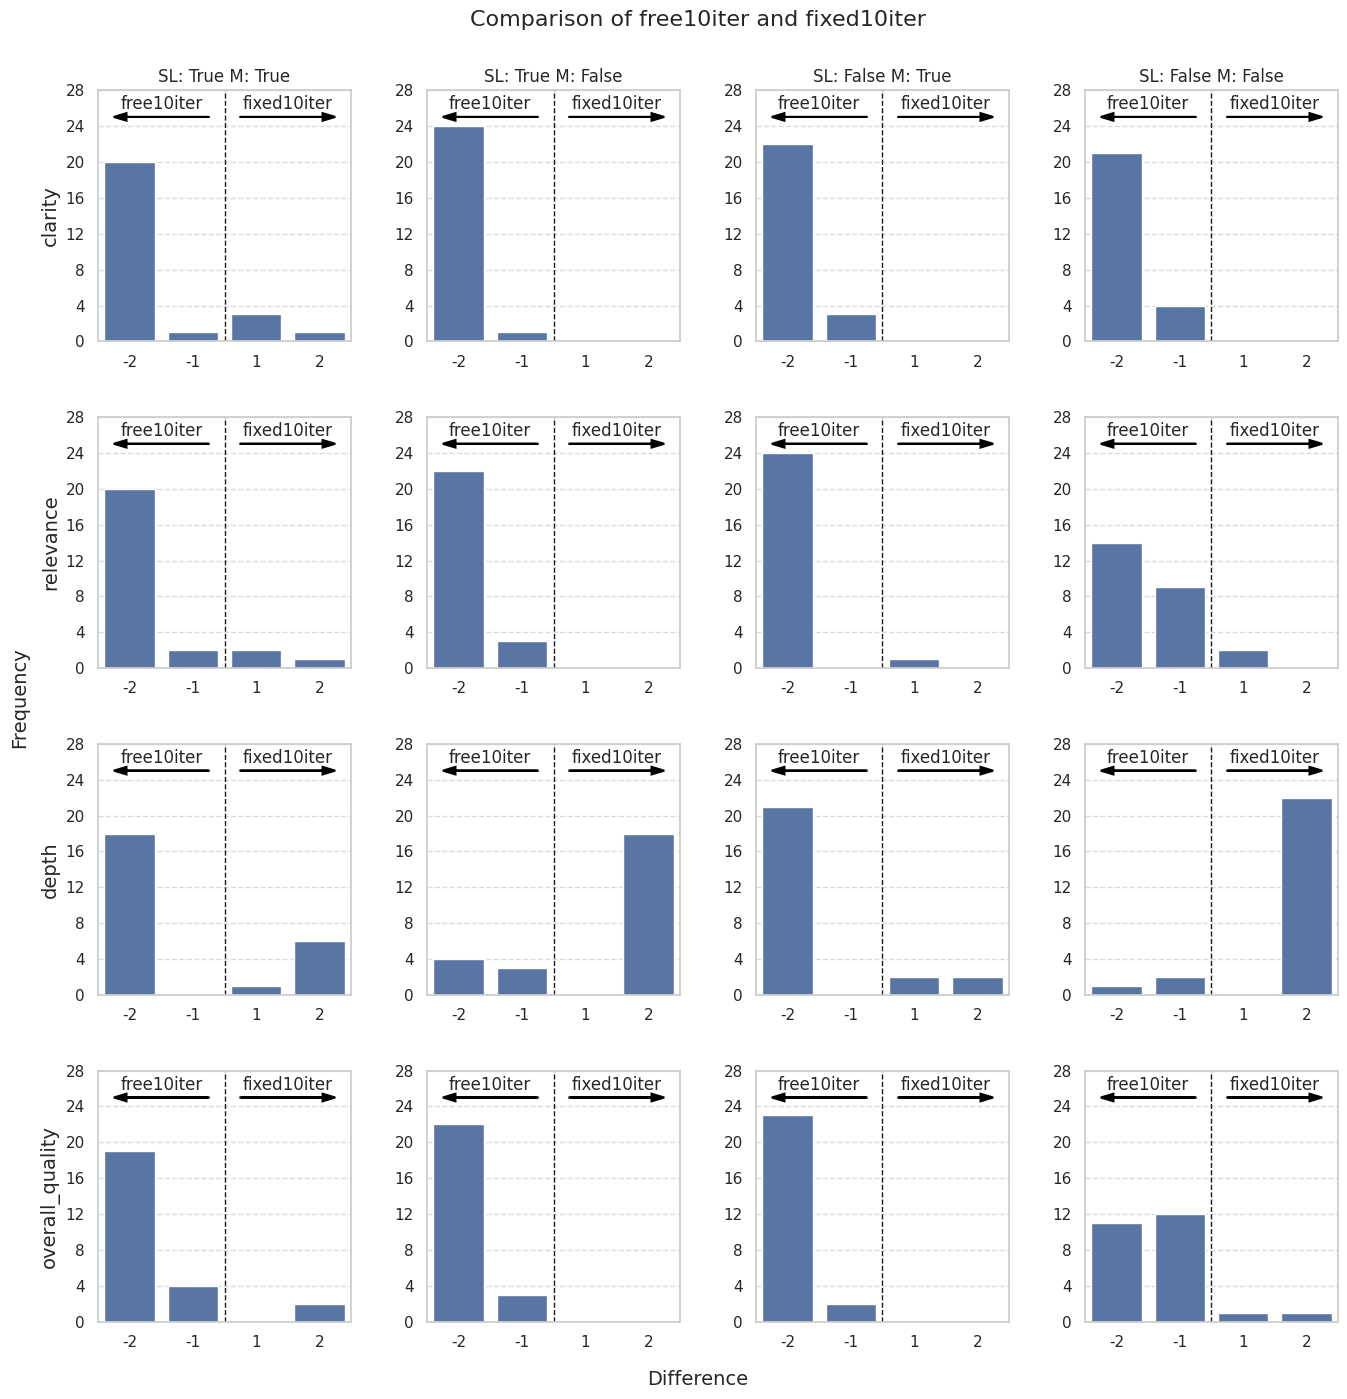

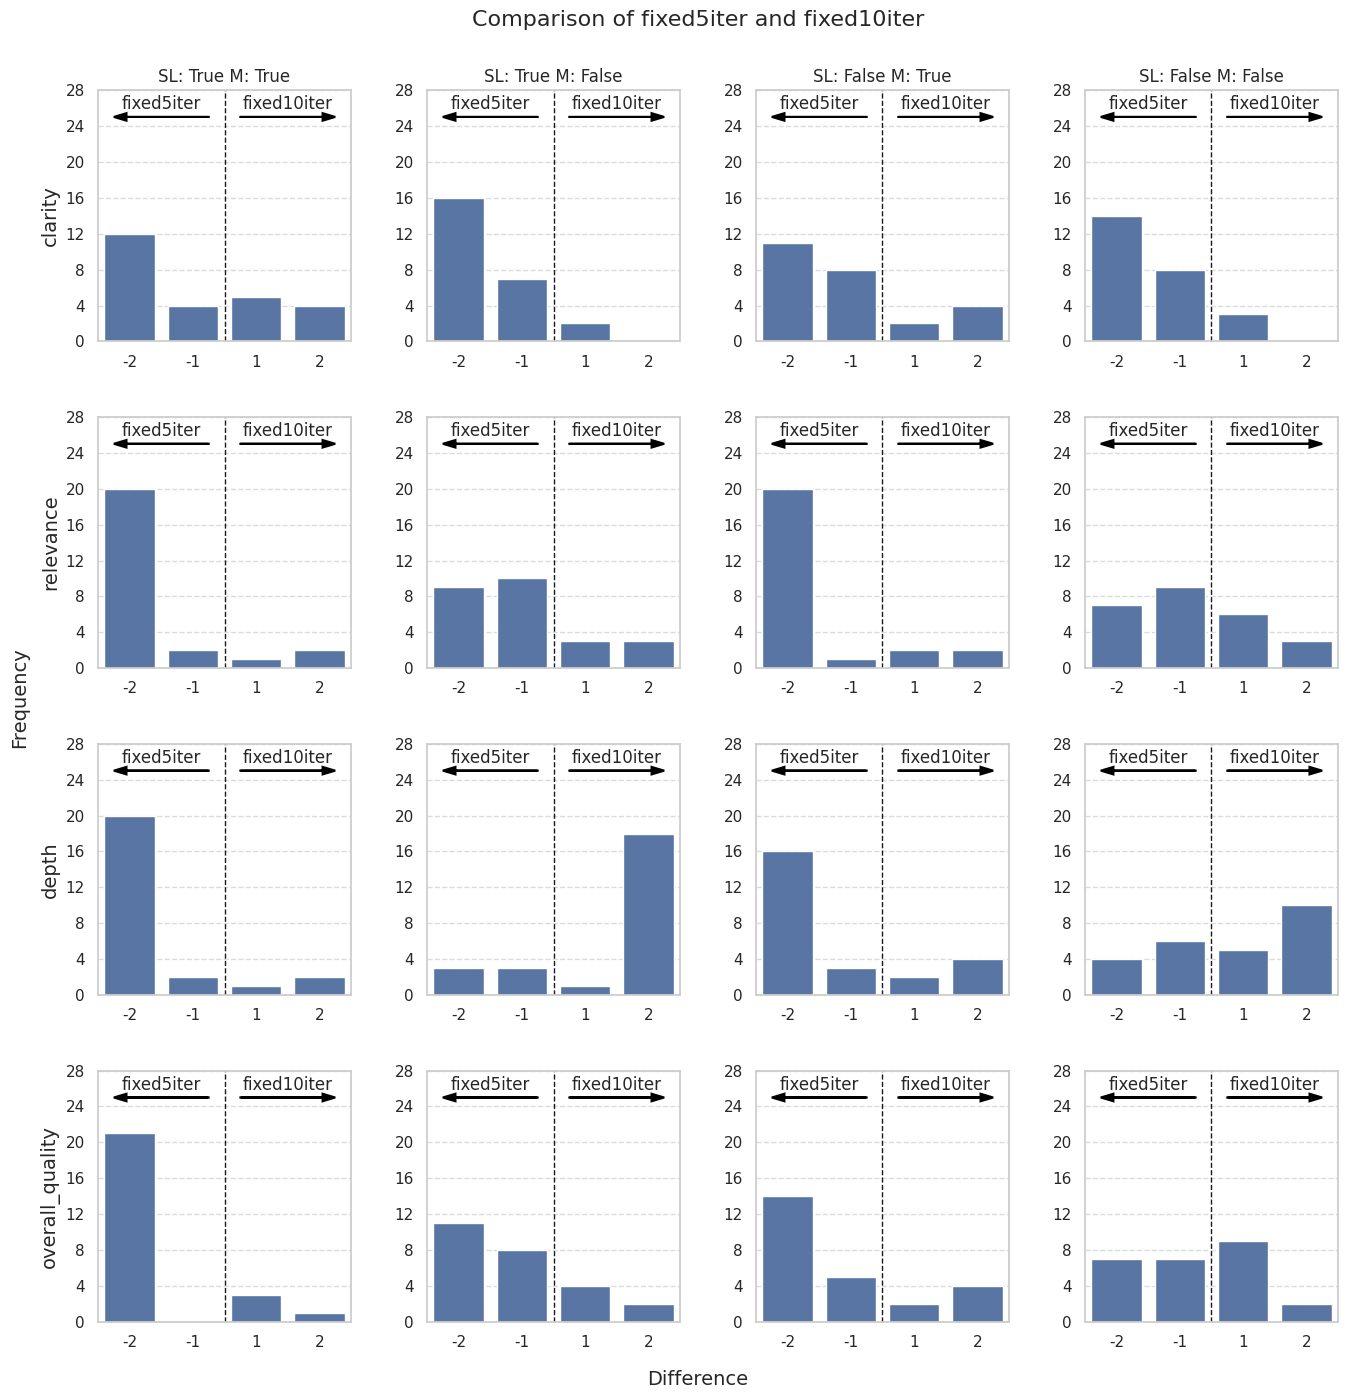

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def draw_arrow(ax, start_x, end_x, y, text):
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin

    dynamic_head_width = yrange * 0.03

    text_x_no_dialogue = (start_x + end_x) / 2

    ax.arrow(start_x, y, (end_x - start_x), 0,
             head_width=dynamic_head_width,
             head_length=0.2,
             fc='black', ec='black', lw=1.5,
             length_includes_head=True)

    ax.text(text_x_no_dialogue,
            y + 0.015 * yrange, text, ha='center', va='bottom')


sns.set_theme(style="whitegrid")

files = ['free10VSfixed5.csv', 'free10VSfixed10.csv', 'fixed5VSfixed10.csv']

for f in files:
    with open(f, 'r') as file:
        data = pd.read_csv(file)

    file1 = data.columns[0]
    file2 = data.columns[4]

    fig, axs = plt.subplots(4, 4, figsize=(16, 16))

    for i, c in enumerate(data['criteria'].unique()):
        fig.suptitle(
            f"Comparison of {file1} and {file2}", fontsize=16, y=0.93)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        if i == 0:
            fig.text(0.5, fig.subplotpars.bottom - 0.03,
                     "Difference", ha='center', va='top', fontsize=14)
            fig.text(0.07, 0.5, "Frequency", va='center',
                     rotation='vertical', fontsize=14)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        for j, comb in enumerate(combinations):
            student_level = comb[0]
            materials = comb[1]

            # Filter the data for the current criteria
            subset = data[data['criteria'] == c]

            # Filter the data for the current combination
            subset = subset[subset[file1 + '_student_level'] == student_level]
            subset = subset[subset[file1 + '_materials'] == materials]
            subset = subset[subset[file2 + '_student_level'] == student_level]
            subset = subset[subset[file2 + '_materials'] == materials]

            difference = subset['difference'].value_counts()

            # Row for each criteria
            # Column for each combination
            ax = axs[i, j]

            sns.barplot(
                x=difference.index,
                y=difference.values,
                ax=ax,
                order=[-2, -1, 1, 2],
            )

            ax.set_xlabel('')
            ax.set_ylabel('')

            # To only the first row add the title
            if i == 0:
                ax.set_title(
                    f"SL: {student_level} M: {materials}")

            # To the first column add the criteria
            if j == 0:
                ax.set_ylabel(c, fontsize=14)

            # Ensure correct labels to values
            ax.set_xlim(-0.5, 3.5)
            ax.set_xticks([0, 1, 2, 3])
            ax.set_xticklabels(['-2', '-1', '1', '2'])

            ax.set_yticks(range(0, 29, 4))
            ax.set_ylim(0, 28)

            ax.axvline(x=1.5, color='k', linestyle='--', linewidth=1)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            # Draw arrows to indicate the direction of the difference
            arrow_y = 25
            draw_arrow(ax, 1.25, -0.25, arrow_y, file1)
            draw_arrow(ax, 1.75, 3.25, arrow_y, file2)

    # plt.savefig(f'Images/{f.split(".")[0]}_all.png', dpi=300, bbox_inches='tight')
    plt.show()

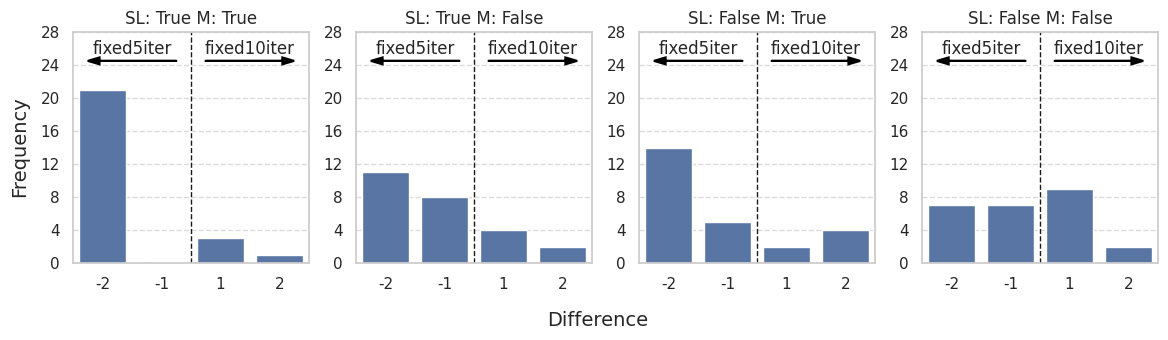

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

with open('fixed5VSfixed10.csv', 'r') as file:
    data = pd.read_csv(file)

    file1 = data.columns[0]
    file2 = data.columns[4]

    fig, axs = plt.subplots(1, 4, figsize=(14, 3))

    for i, c in enumerate(['overall_quality']):
        if i == 0:
            fig.text(0.5, -0.1, "Difference", ha='center', fontsize=14)
            fig.text(0.08, 0.5, "Frequency", va='center',
                     rotation='vertical', fontsize=14)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        for j, comb in enumerate(combinations):
            student_level = comb[0]
            materials = comb[1]

            # Filter the data for the current criteria
            subset = data[data['criteria'] == c]

            # Filter the data for the current combination
            subset = subset[subset[file1 + '_student_level'] == student_level]
            subset = subset[subset[file1 + '_materials'] == materials]
            subset = subset[subset[file2 + '_student_level'] == student_level]
            subset = subset[subset[file2 + '_materials'] == materials]

            bestIter = subset['difference'].value_counts()

            ax = axs[j]

            sns.barplot(
                x=bestIter.index,
                y=bestIter.values,
                ax=ax,
                order=[-2, -1, 1, 2],
            )

            ax.set_xlabel('')
            ax.set_ylabel('')

            # To only the first row add the title
            if i == 0:
                ax.set_title(
                    f"SL: {student_level} M: {materials}")

            ax.set_xlim(-0.5, 3.5)
            ax.set_xticks([0, 1, 2, 3])
            ax.set_xticklabels(['-2', '-1', '1', '2'])

            ax.set_yticks(range(0, 29, 4))
            ax.set_ylim(0, 28)

            ax.axvline(x=1.5, color='k', linestyle='--', linewidth=1)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            arrow_y = 24.5
            draw_arrow(ax, 1.25, -0.25, arrow_y, file1)
            draw_arrow(ax, 1.75, 3.25, arrow_y, file2)

    # plt.savefig(f'Images/fixed5VSfixed10_overall_quality.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
"""
Total approximate amount of USD spent:
30.22914935
"""

In [ ]:
total_cost = 0.34097360000000004
number_of_questions = 40
criteria = 4

# Cost per call
cost_per_call = total_cost / number_of_questions / criteria
print("Cost per call for each criteria:", cost_per_call)

# Approximate cost for having three files each with x questions
questions = 10
combinations = 4
files = 3
attempts = 1

total_questions = files * questions * combinations * \
    questions * combinations * attempts * criteria
approx_cost = cost_per_call * total_questions

print("Total questions:", total_questions)
print("Approximate cost for comparing", files, "files each with",
      questions, "questions and", attempts, "attempts:", approx_cost)

Cost per call for each criteria: 0.0021310850000000004
Total questions: 19200
Approximate cost for comparing 3 files each with 10 questions and 1 attempts: 40.91683200000001


In [1]:
# Create fixed5iter.json from fixed10iter.json
# The number of tokens used is taken as approximately half of the original, as this was not called by the API
import json

with open('fixed10iter.json', 'r') as f:
    data = json.load(f)

for item in data:
    # Remove last 10 messages from the assistant and teacher history
    item['student'] = item['student'][:-10]
    item['teacher'] = item['teacher'][:-10]
    item['metadata']['iterations'] = 5
    item['metadata']['prompt_tokens'] = item['metadata']['prompt_tokens'] // 2
    item['metadata']['completion_tokens'] = item['metadata']['completion_tokens'] // 2
    item['metadata']['total_tokens'] = item['metadata']['total_tokens'] // 2

with open('fixed5iter.json', 'w') as f:
    json.dump(data, f, indent=4)